In [1]:
import bh_spc
from bh_spc import spcm

import time
import matplotlib.pyplot as plt
import numpy as np

In [2]:
spcm.init(r'C:\EXP\python\Qoptics_exp\new_settings.ini')

In [3]:
mod_no = 0

In [18]:
spcm.get_init_status(mod_no)
spcm.set_mode(spcm.DLLOperationMode.HARDWARE, True, [True])
status = spcm.get_init_status(mod_no)
print(status == spcm.InitStatus.OK)

True


In [5]:
spcm.set_parameter(mod_no, spcm.ParID.MODE, 1)

In [23]:
params = spcm.get_parameters(mod_no)

#for par, val in params.items():
#    print(f"{par} = {val}")

print(params)

<Data(cfd_limit_low=-49.01960754394531, cfd_limit_high=5.019608020782471, cfd_zc_level=-9.82677173614502, cfd_holdoff=5.0, sync_zc_level=-9.82677173614502, sync_freq_div=4, sync_holdoff=4.0, sync_threshold=-41.17647171020508, tac_range=50.033573150634766, tac_gain=1, tac_offset=3.9215686321258545, tac_limit_low=4.705882549285889, tac_limit_high=92.94117736816406, adc_resolution=12, ext_latch_delay=0, collect_time=3.0, display_time=1.0, repeat_time=300.0, stop_on_time=0, stop_on_ovfl=0, dither_range=128, count_incr=1, mem_bank=0, dead_time_comp=0, scan_control=0, routing_mode=0, tac_enable_hold=0.0, mode=1, scan_size_x=1, scan_size_y=1, scan_rout_x=1, scan_rout_y=1, scan_polarity=0, scan_flyback=65537, scan_borders=0, pixel_time=2.0000000233721948e-07, pixel_clock=0, line_compression=1, trigger=0, ext_pixclk_div=1, rate_count_time=1.0, macro_time_clk=0, add_select=0, adc_zoom=0, xy_gain=1, img_size_x=1, img_size_y=1, img_rout_x=1, img_rout_y=1, master_clock=0, adc_sample_delay=0, detect

In [24]:
# For this demonstration, we will turn off `stop_on_time`, mostly because it
# does not appear to work in simulation mode. By turning it off, running this
# example on real hardware should behave the same way.
params.stop_on_time = 1

# (Set other parameters here!)

spcm.set_parameters(mod_no, params)

In [25]:
duration = 3 # s
buf_size = 32768  # Max number of 16-bit words in a single read.

spcm.start_measurement(mod_no)
start_time = time.monotonic()

data = []  # Collect arrays of data into a list.
while True:
    elapsed = time.monotonic() - start_time
    if elapsed >= duration:
        spcm.stop_measurement(mod_no)
        break
    buf = spcm.read_fifo_to_array(mod_no, buf_size)
    if len(buf):
        data.append(buf)
    if len(buf) < buf_size:  # We've read all there is to read.
        time.sleep(0.001)

# Make sure to read the data that arrived after stopping (if you need it).
while True:
    buf = spcm.read_fifo_to_array(mod_no, buf_size)
    if not len(buf):
        break
    data.append(buf)

In [26]:
records = np.concatenate(data).view(np.uint32)
len(records)

37136

In [27]:
had_gap = np.any(np.bitwise_and(records, 1 << 29))
print("There was {} gap".format("a" if had_gap else "no"))

There was no gap


In [28]:
photons = np.extract(np.bitwise_and(records, 0b1001 << 28) == 0, records)
len(photons)

25579

In [29]:
max_12bit = (1 << 12) - 1  # 4095
microtimes = np.bitwise_and(np.right_shift(photons, 16), max_12bit)

# Reverse the microtimes by subtracting from the max value, because the raw
# microtime is measured from photon to SYNC, not SYNC to photon.
microtimes = max_12bit - microtimes

#h = plt.hist(microtimes, bins=64)

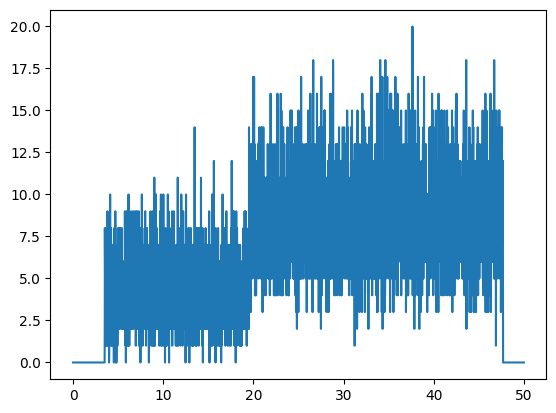

In [30]:
time_bins = np.arange(4096) #* data.tac_range / 4096
histogram, bin_edges = np.histogram(microtimes, bins=time_bins)
bin_edges = bin_edges[:-1] * params.tac_range / 4096
plt.plot(bin_edges, histogram)
plt.show()